# Yugoslavia’s CO₂ Emmisions

### 1. Key Research Questions
How do CO2 emissions differ between these countries over time?

Is there a correlation between GDP growth and CO2 emissions?

Which country has the highest/lowest emissions per capita?

How did the breakup of Yugoslavia (1990s) affect emissions trends?

Do EU membership (Slovenia, Croatia) and energy policies impact emissions differently?



In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Data Loading

To begin the project, we explored available databases related to pollution and CO2 emissions. After gathering the data from online sources, we organized it into appropriate folders and integrated it into our code.

In [2]:
data_root = './data/'
data_root_world = './data/cultural/'

In [3]:
# Reading the data
df_co2 = pd.read_csv(f'{data_root}co2_emmisions_complicated.csv')
df_gdp = pd.read_csv(f'{data_root}co2-emissions-vs-gdp.csv')
world = gpd.read_file(f'{data_root_world}ne_110m_admin_0_countries.shp')

In [4]:
df_co2_europe = df_co2[df_co2['Region'].str.contains('Europe', case=False, na=False)]

row = df_co2_europe[df_co2_europe['Name'] == 'Serbia and Montenegro'].copy()

serbia_row = row.copy()
montenegro_row = row.copy()

serbia_row['Country_code'] = 'SRB'
serbia_row['Name'] = 'Serbia'

montenegro_row['Country_code'] = 'MNE'
montenegro_row['Name'] = 'Montenegro'

year_columns = [col for col in df_co2_europe.columns if col.isdigit()]

# Split the CO2 data by 85% and 15% because Serbia is much bigger than Montenegro by area and by population
serbia_row[year_columns] = row[year_columns] * 0.96
montenegro_row[year_columns] = row[year_columns] * 0.04

# Drop the original Serbia and Montenegro row
df_co2_europe = df_co2_europe[df_co2_europe['Name'] != 'Serbia and Montenegro']

# Append the two new rows
df_co2_europe = pd.concat([df_co2_europe, serbia_row, montenegro_row], ignore_index=True)

In [5]:
yugo_countries = ['Serbia', 'North Macedonia', 'Bosnia and Herzegovina', 'Montenegro', 'Croatia', 'Slovenia']
yugo_df = df_co2_europe[df_co2_europe['Name'].isin(yugo_countries)]

In [6]:
# Convert year columns from wide to long format
yugo_long = yugo_df.melt(
    id_vars=['Region', 'Country_code', 'Name', 'Substance'],
    var_name='year',
    value_name='value'
)

# Convert 'year' to int
yugo_long['year'] = yugo_long['year'].astype(int)

In [7]:
df_gdp_yugo = df_gdp[df_gdp['Entity'].isin(yugo_countries)].copy()

In [8]:
yugo_long

,Region,Country_code,Name,Substance,year,value
0,Central Europe,BIH,Bosnia and Herzegovina,CO2,1970,11536.438150
1,Central Europe,HRV,Croatia,CO2,1970,21812.449000
2,Central Europe,MKD,North Macedonia,CO2,1970,9101.273488
3,Central Europe,SVN,Slovenia,CO2,1970,10433.804550
4,Central Europe,SRB,Serbia,CO2,1970,29025.120058
...,...,...,...,...,...,...
319,Central Europe,HRV,Croatia,CO2,2023,17456.501590
320,Central Europe,MKD,North Macedonia,CO2,2023,8763.655053
321,Central Europe,SVN,Slovenia,CO2,2023,12076.461040
322,Central Europe,SRB,Serbia,CO2,2023,53876.086704


In [9]:
df_gdp_yugo.rename(columns={'Entity': 'Name'}, inplace=True)
yugo_long.rename(columns={'year': 'Year'}, inplace=True)

combined_df = pd.merge(yugo_long, df_gdp_yugo, on=['Name', 'Year'])


### Before the Breakup: Patterns in Yugoslav Republics

As the six countries that once formed Yugoslavia shared a unified economy, energy infrastructure, and industrial policy, we were curious to explore whether this common foundation also led to similar levels of CO₂ emissions per capita. 

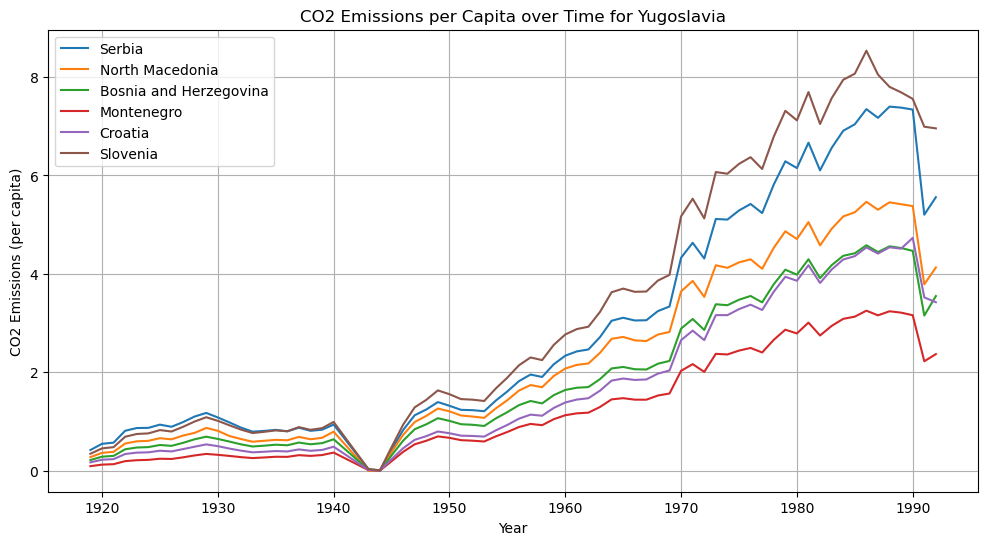

In [10]:
yugo_filtered = df_gdp_yugo[(df_gdp_yugo['Year'] >= 1918) & (df_gdp_yugo['Year'] <= 1992)]

plt.figure(figsize=(12, 6))

for country in yugo_countries:
    country_data = yugo_filtered[yugo_filtered['Name'] == country]
    plt.plot(country_data['Year'], country_data['Annual CO₂ emissions (per capita)'], label=country)

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (per capita)')
plt.title('CO2 Emissions per Capita over Time for Yugoslavia')
plt.legend()
plt.grid(True)
plt.show()

The similarity in CO₂ emissions per capita trends among the former Yugoslav countries until the early 2000s reflects their shared industrial history and centralized energy systems. This supports the idea that they operated as a single environmental and economic unit during Yugoslavia.

**General Trend:**
CO2 emissions per capita were very low (near zero) until ~1950, reflecting pre-industrial and agrarian economies.
A sharp rise begins in the 1950s, coinciding with Yugoslavia’s industrialization under Tito’s socialist regime.

**Divergence Post-1960s:**
Emissions diverge by country after 1960, likely due to:
Industrialization differences: Slovenia and Serbia (more developed) may have had higher emissions early on.

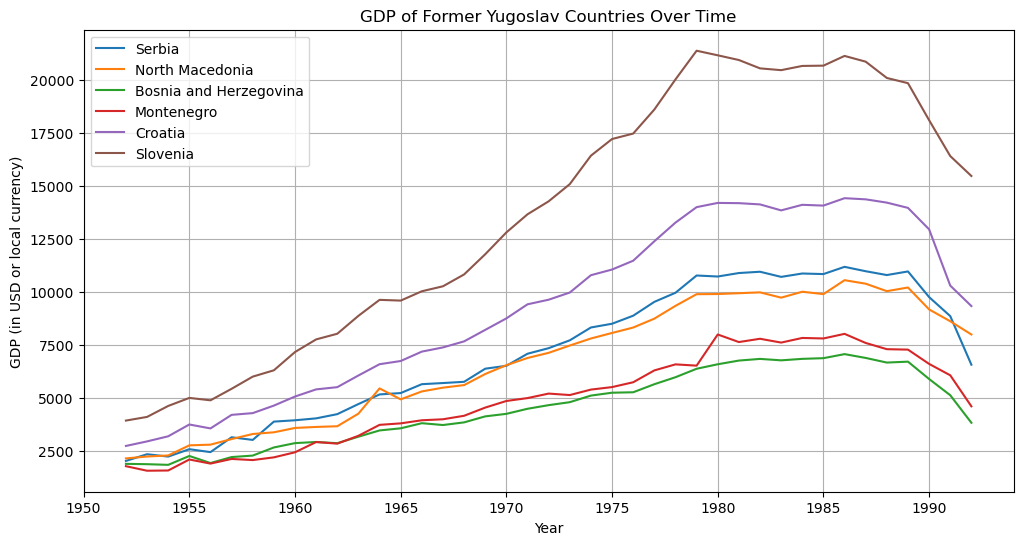

In [11]:
plt.figure(figsize=(12, 6))
for country in yugo_countries:
    country_data = yugo_filtered[yugo_filtered['Name'] == country]
    plt.plot(country_data['Year'], country_data['GDP per capita'], label=country)

plt.title('GDP of Former Yugoslav Countries Over Time')
plt.xlabel('Year')
plt.ylabel('GDP (in USD or local currency)')
plt.legend()
plt.grid(True)
plt.show()

GDP per capita among the republics was relatively similar, reflecting a shared economic system and central planning. However, starting in the 1980s, slight divergences began to appear. These differences were likely due to growing regional economic disparities, uneven development, and the broader economic crisis Yugoslavia faced during that decade—including rising debt, inflation, and political instability. This early divergence foreshadowed the deeper economic separation that would follow independence.

Regions with higher or growing GDP (like *Slovenia* or *Croatia*) may have had more industrial activity, resulting in higher CO₂ emissions.

Regions with stagnating or lower GDP may have emitted less CO₂ due to weaker industrial output or underinvestment.

In [12]:
# Drop rows with missing essential values
yugo_filtered = yugo_filtered.dropna(subset=['GDP per capita', 'Annual CO₂ emissions (per capita)', 'Population (historical)'])

# Calculate total GDP and total CO2 per year per country
yugo_filtered['Total GDP'] = yugo_filtered['GDP per capita'] * yugo_filtered['Population (historical)']
yugo_filtered['Total CO2'] = yugo_filtered['Annual CO₂ emissions (per capita)'] * yugo_filtered['Population (historical)']

# Calculate CO2 per dollar and per million dollars of GDP
yugo_filtered['CO2 per dollar'] = yugo_filtered['Total CO2'] / yugo_filtered['Total GDP']
yugo_filtered['CO2 per million dollars'] = yugo_filtered['CO2 per dollar'] * 1_000_000

# Now compute the average values per country across years
summary_df = yugo_filtered.groupby('Name').agg({
    'Total GDP': 'mean',
    'Total CO2': 'mean',
    'CO2 per dollar': 'mean',
    'CO2 per million dollars': 'mean'
}).reset_index()

# Sort to find most and least efficient countries
summary_best = summary_df.sort_values(by='CO2 per million dollars', ascending=True)
summary_worst = summary_df.sort_values(by='CO2 per million dollars', ascending=False)

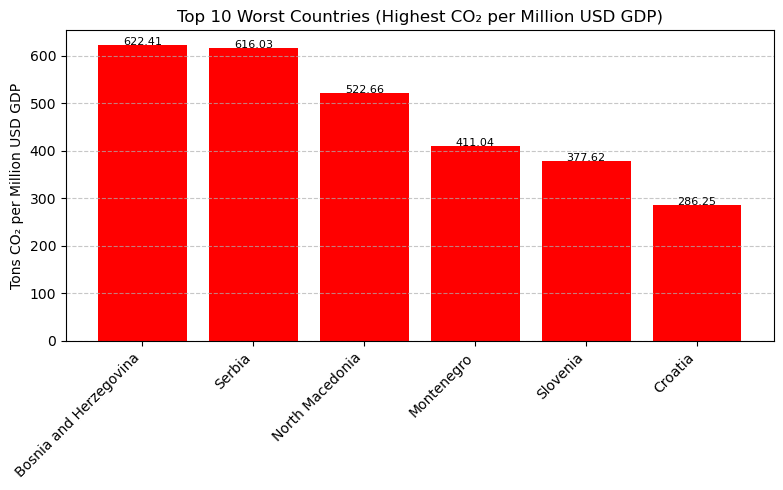

,Name,Total GDP,Total CO2,CO2 per dollar,CO2 per million dollars
0,Bosnia and Herzegovina,1.795414e+10,1.142037e+07,0.000622,622.413218
4,Serbia,5.343122e+10,3.316802e+07,0.000616,616.031976
3,North Macedonia,1.225639e+10,6.316525e+06,0.000523,522.662237
2,Montenegro,2.754764e+09,1.127312e+06,0.000411,411.038250
5,Slovenia,2.498050e+10,9.408888e+06,0.000378,377.622299
1,Croatia,4.236483e+10,1.245638e+07,0.000286,286.250251


In [13]:
# === WORST COUNTRIES ===
plt.figure(figsize=(8, 5))
plt.bar(summary_worst['Name'].head(10), summary_worst['CO2 per million dollars'].head(10), color='red')
plt.title('Top 10 Worst Countries (Highest CO₂ per Million USD GDP)')
plt.ylabel('Tons CO₂ per Million USD GDP')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# value labels
for i, val in enumerate(summary_worst['CO2 per million dollars'].head(10)):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# print out the countries
summary_worst.head(10)

### After the Breakup 

However, differences emerging in later years — with some countries increasing emissions per capita while others stabilize or decline — highlight the impact of independent policy choices, economic reform pace, and international alignment (such as EU accession)."

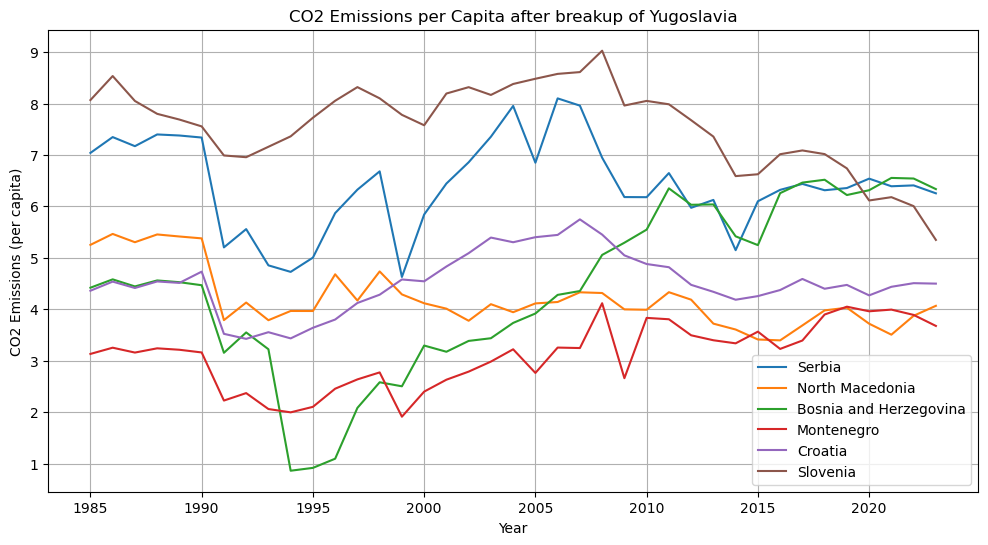

In [14]:
yugo_breakup = df_gdp_yugo[(df_gdp_yugo['Year'] >= 1985)]

plt.figure(figsize=(12, 6))

for country in yugo_countries:
    country_data = yugo_breakup[yugo_breakup['Name'] == country]
    plt.plot(country_data['Year'], country_data['Annual CO₂ emissions (per capita)'], label=country)

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (per capita)')
plt.title('CO2 Emissions per Capita after breakup of Yugoslavia')
plt.legend()
plt.grid(True)
plt.show()

**General Trends *(1985–2020)***

**Pre-breakup (1985–1990):** 
Emissions were relatively stable, reflecting Yugoslavia’s unified industrial policies.

**Post-breakup (1990s):**
Likely a drop in emissions due to economic collapse, war devastation, and halted industrial activity (especially in Bosnia, Serbia, and Croatia).

**2000s Recovery:**
Gradual increase as economies stabilized, but divergence emerges based on energy policies and EU integration.

**2010s–2020:**
EU members (Slovenia, Croatia): Emissions decline due to stricter environmental regulations and renewable energy adoption.
Non-EU countries (Serbia, Bosnia, N. Macedonia, Montenegro): Emissions remain higher, tied to coal dependence and slower green transitions.

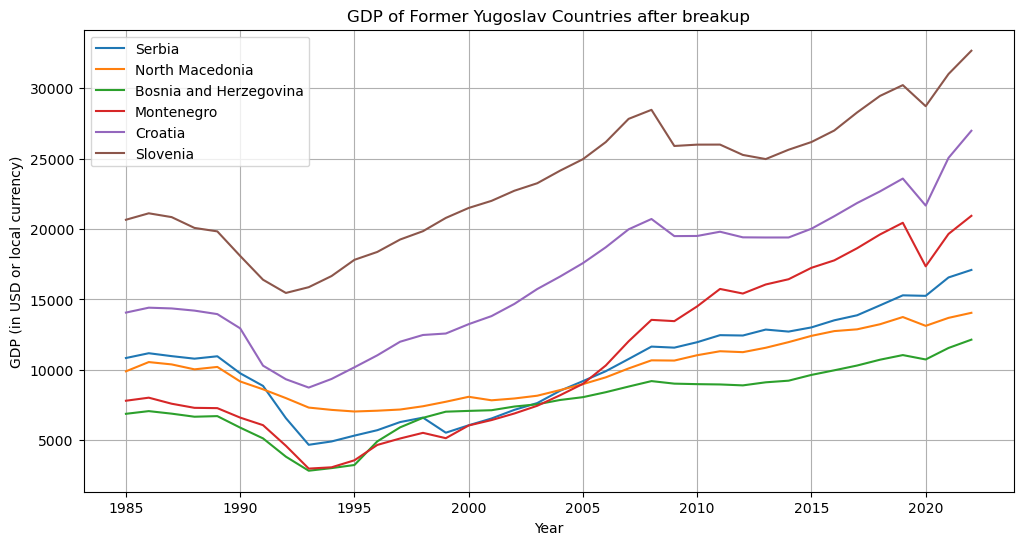

In [15]:
plt.figure(figsize=(12, 6))
for country in yugo_countries:
    country_data = yugo_breakup[yugo_breakup['Name'] == country]
    plt.plot(country_data['Year'], country_data['GDP per capita'], label=country)

plt.title('GDP of Former Yugoslav Countries after breakup')
plt.xlabel('Year')
plt.ylabel('GDP (in USD or local currency)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Drop rows with missing essential values
yugo_breakup = yugo_breakup.dropna(subset=['GDP per capita', 'Annual CO₂ emissions (per capita)', 'Population (historical)'])

# Calculate total GDP and total CO2 per year per country
yugo_breakup['Total GDP'] = yugo_breakup['GDP per capita'] * yugo_breakup['Population (historical)']
yugo_breakup['Total CO2'] = yugo_breakup['Annual CO₂ emissions (per capita)'] * yugo_breakup['Population (historical)']

# Calculate CO2 per dollar and per million dollars of GDP
yugo_breakup['CO2 per dollar'] = yugo_breakup['Total CO2'] / yugo_breakup['Total GDP']
yugo_breakup['CO2 per million dollars'] = yugo_breakup['CO2 per dollar'] * 1_000_000

# Now compute the average values per country across years
summary_df = yugo_breakup.groupby('Name').agg({
    'Total GDP': 'mean',
    'Total CO2': 'mean',
    'CO2 per dollar': 'mean',
    'CO2 per million dollars': 'mean'
}).reset_index()

# Sort to find most and least efficient countries
summary_best = summary_df.sort_values(by='CO2 per million dollars', ascending=True)
summary_worst = summary_df.sort_values(by='CO2 per million dollars', ascending=False)

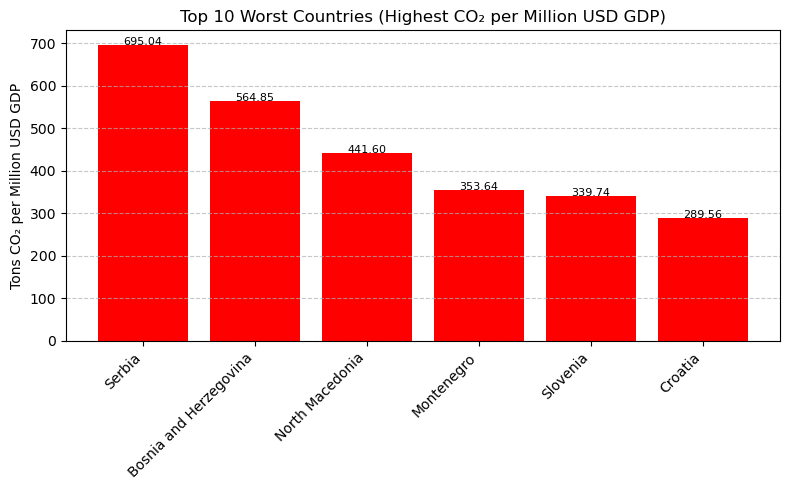

,Name,Total GDP,Total CO2,CO2 per dollar,CO2 per million dollars
4,Serbia,7.613772e+10,4.825089e+07,0.000695,695.041967
0,Bosnia and Herzegovina,2.978257e+10,1.682270e+07,0.000565,564.851340
3,North Macedonia,2.013274e+10,8.503342e+06,0.000442,441.599576
2,Montenegro,6.708223e+09,1.932710e+06,0.000354,353.643800
5,Slovenia,4.742865e+10,1.538071e+07,0.000340,339.744839
1,Croatia,7.183099e+10,1.979232e+07,0.000290,289.559137


In [17]:
# === WORST COUNTRIES ===
plt.figure(figsize=(8, 5))
plt.bar(summary_worst['Name'].head(10), summary_worst['CO2 per million dollars'].head(10), color='red')
plt.title('Top 10 Worst Countries (Highest CO₂ per Million USD GDP)')
plt.ylabel('Tons CO₂ per Million USD GDP')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# value labels
for i, val in enumerate(summary_worst['CO2 per million dollars'].head(10)):
    plt.text(i, val + 0.01, f"{val:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# print out the countries
summary_worst.head(10)

#### EU Countries

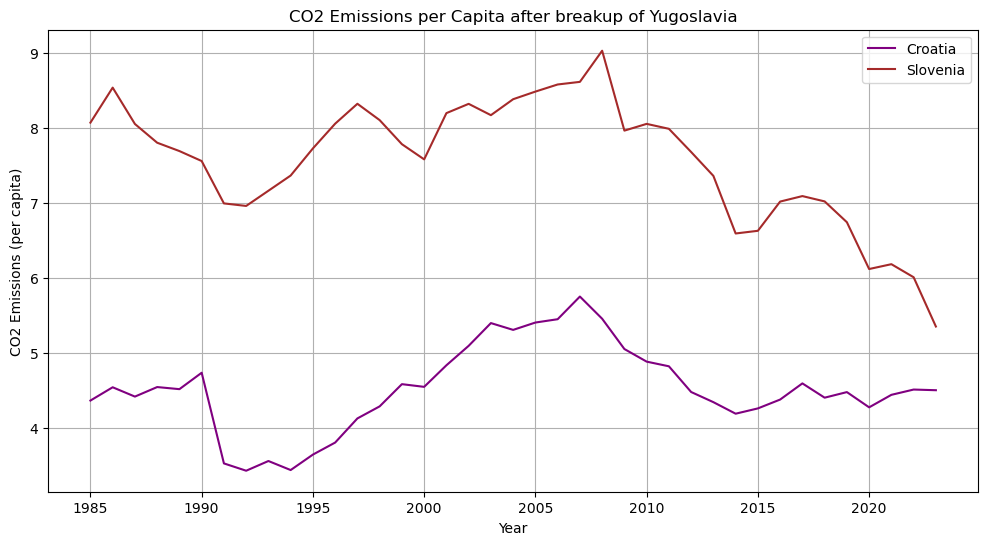

In [18]:
yugo_breakup = df_gdp_yugo[(df_gdp_yugo['Year'] >= 1985)]

plt.figure(figsize=(12, 6))

croatia = yugo_breakup[yugo_breakup['Name'] == 'Croatia']
slovenia = yugo_breakup[yugo_breakup['Name'] == 'Slovenia']

plt.plot(croatia['Year'], croatia['Annual CO₂ emissions (per capita)'], label='Croatia', color="purple")
plt.plot(country_data['Year'], country_data['Annual CO₂ emissions (per capita)'], label='Slovenia', color="brown")

plt.xlabel('Year')
plt.ylabel('CO2 Emissions (per capita)')
plt.title('CO2 Emissions per Capita after breakup of Yugoslavia')
plt.legend()
plt.grid(True)
plt.show()

##### Slovenia & Croatia:
After joining the European Union, both Slovenia and Croatia began to significantly reduce their CO₂ emissions. This shift was driven by stricter EU environmental regulations, increased investment in renewable energy sources, and improvements in energy efficiency. While emissions declined or plateaued, their economies continued to grow—showing a clear decoupling between economic development and environmental impact.

In [19]:
eu_members = yugo_breakup[yugo_breakup['Name'].isin(['Slovenia', 'Croatia'])]

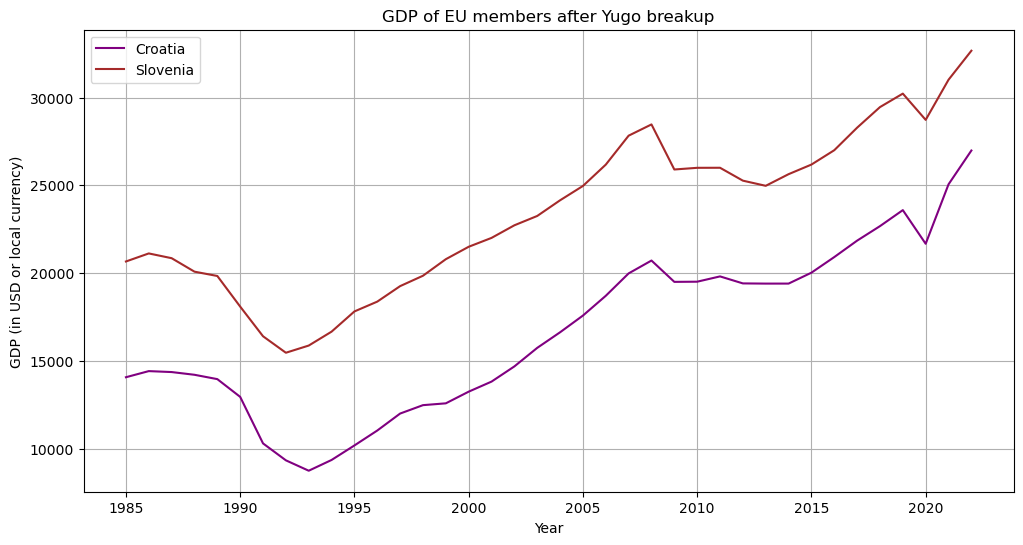

In [20]:
plt.figure(figsize=(12, 6))
croatia = yugo_breakup[yugo_breakup['Name'] == 'Croatia']
slovenia = yugo_breakup[yugo_breakup['Name'] == 'Slovenia']

plt.plot(croatia['Year'], croatia['GDP per capita'], label='Croatia', color="purple")
plt.plot(country_data['Year'], country_data['GDP per capita'], label='Slovenia', color="brown")

plt.title('GDP of EU members after Yugo breakup')
plt.xlabel('Year')
plt.ylabel('GDP (in USD or local currency)')
plt.legend()
plt.grid(True)
plt.show()

#### Non-EU Countries

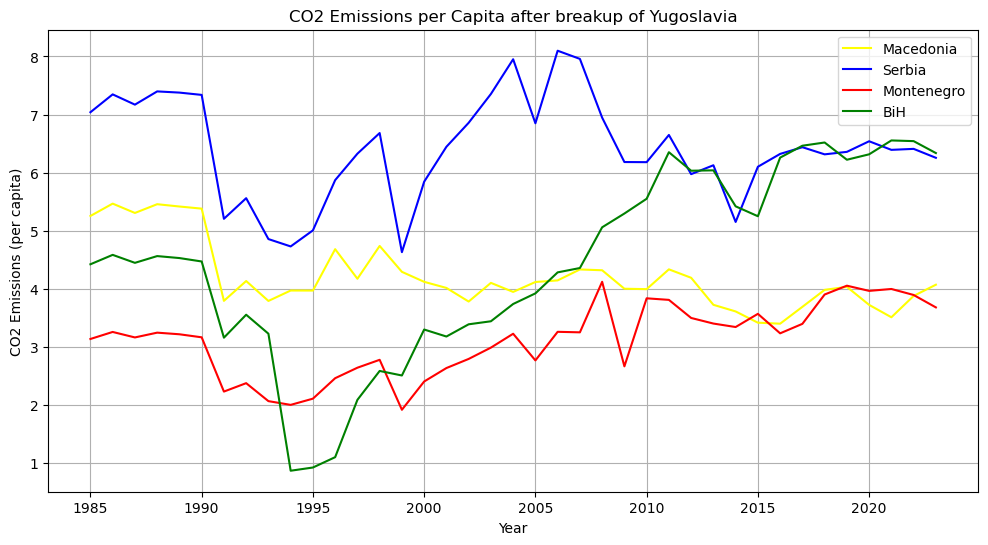

In [21]:
yugo_breakup = df_gdp_yugo[(df_gdp_yugo['Year'] >= 1985)]

plt.figure(figsize=(12, 6))

macedonia = yugo_breakup[yugo_breakup['Name'] == 'North Macedonia']
serbia = yugo_breakup[yugo_breakup['Name'] == 'Serbia']
montenegro = yugo_breakup[yugo_breakup['Name'] == 'Montenegro']
bih = yugo_breakup[yugo_breakup['Name'] == 'Bosnia and Herzegovina']



plt.plot(macedonia['Year'], macedonia['Annual CO₂ emissions (per capita)'], label='Macedonia', color="yellow")
plt.plot(serbia['Year'], serbia['Annual CO₂ emissions (per capita)'], label='Serbia', color="blue")
plt.plot(montenegro['Year'], montenegro['Annual CO₂ emissions (per capita)'], label='Montenegro', color="red")
plt.plot(bih['Year'], bih['Annual CO₂ emissions (per capita)'], label='BiH', color="green")


plt.xlabel('Year')
plt.ylabel('CO2 Emissions (per capita)')
plt.title('CO2 Emissions per Capita after breakup of Yugoslavia')
plt.legend()
plt.grid(True)
plt.show()

**The Bosnian War (1992–1995):** was a devastating conflict that followed the breakup of Yugoslavia.

During this time, industrial production halted, infrastructure was heavily damaged, and the economy collapsed.
Reliable data collection was also extremely difficult due to the chaos and destruction, which is why some datasets show missing or zero emissions.
Even where data is available, emissions were likely extremely low because factories were shut down, electricity grids were disrupted, and fuel use plummeted.

**Macedonia:**

Unlike some other former Yugoslav republics, Macedonia gained independence peacefully, without the destruction of war. As a result, its economy and industrial activity remained relatively stable during the 1990s. This is reflected in its CO₂ emissions, which show a more consistent and steady trend over time compared to countries affected by conflict.

**Serbia & Montenegro:**

Serbia and Montenegro followed a similar path in CO₂ emissions, largely because they remained united as a single country (Federal Republic of Yugoslavia) from 1992 until their separation in 2006. During this period, they shared economic policies, energy infrastructure, and industrial sectors. This close economic and political connection likely explains the similar trends in their CO₂ emissions, reflecting common challenges such as post-war recovery, reliance on coal, and slower progress toward clean energy.

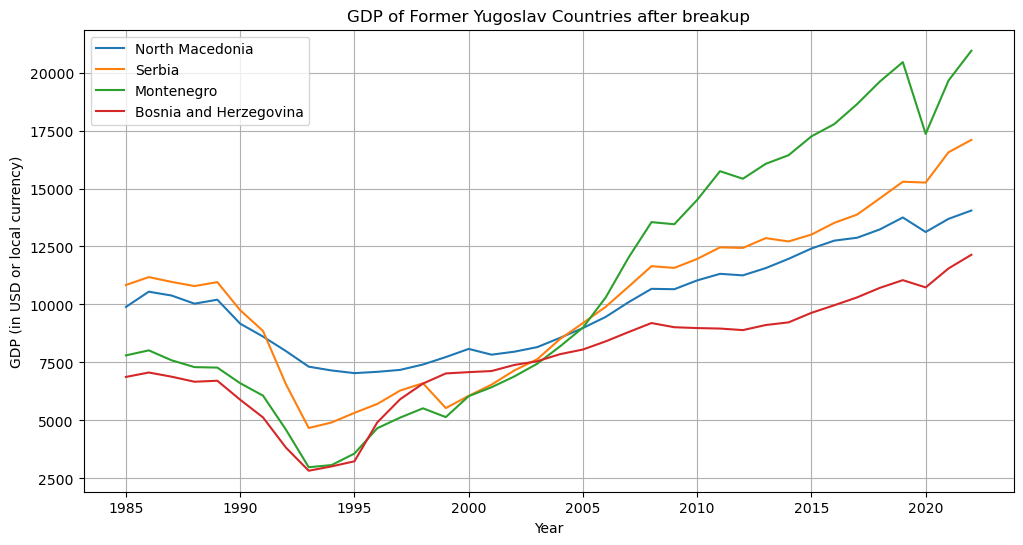

In [22]:
noneu = ['North Macedonia', 'Serbia', 'Montenegro', 'Bosnia and Herzegovina']
plt.figure(figsize=(12, 6))
for country in noneu:
    country_data = yugo_breakup[yugo_breakup['Name'] == country]
    plt.plot(country_data['Year'], country_data['GDP per capita'], label=country)

plt.title('GDP of Former Yugoslav Countries after breakup')
plt.xlabel('Year')
plt.ylabel('GDP (in USD or local currency)')
plt.legend()
plt.grid(True)
plt.show()

### Sharp GDP drop in all countries during the 1990s:
- Wars (Bosnian War 1992–1995, sanctions on Serbia).
- Industrial collapse: Breakdown of integrated Yugoslav economy.
- Hyperinflation: Especially in Serbia (e.g., 1993 inflation peaked at 313 million percent).

### Recovery (2000s–2010s):

**Serbia:**
Fastest recovery post-2000 due to foreign investment (e.g., automotive sector in Kragujevac).
GDP surpasses others by 2020.

**Montenegro:**
Growth spikes post-2006 independence (tourism, real estate).

**Bosnia & Macedonia:**
Slower growth due to political instability, weak institutions, and reliance on remittances.